# <span style="color:green"> Numerical Simulation Laboratory (NSL) </span>
## <span style="color:blue">  Numerical exercises 5</span>


In quantum physics a **wave function**, $\Psi$, is a mathematical description of the state of a quantum system. The wave function is a complex-valued probability amplitude, and the probabilities for the possible results of measurements made on the system can be derived from it.

For now on, let's consider the simple case of a non-relativistic single particle, without spin, in three spatial dimensions. The state of such a particle is completely described by its wave function, $\Psi(\vec{r},t)$, where $\vec{r}$ is position and $t$ is time.

For one spinless particle, if the wave function is interpreted as a probability amplitude, the square modulus of the wave function, $|\Psi(\vec{r},t)|^2$, is interpreted as the probability density that the particle is at $\vec{r}$ at time $t$. Once we have a probability density, we can use Monte Carlo ...

#### Hydrogen atom
The wave functions of the eigenstates of an electron in a Hydrogen atom (this is the only atom for which the Schroedinger equation has been solved exactly) are expressed in terms of spherical harmonics and generalized Laguerre polynomials. It is convenient to use spherical coordinates, and the wave function can be separated into functions of each coordinate:

$$
\Psi_{n,l,m}(r,\theta,\phi)=
\sqrt{\left(\frac{2}{na_0}\right)^3 \frac{(n-l-1)!}{2n[(n+l)!]}}
e^{-r/na_0}\left(\frac{2r}{na_0}\right)^l L_{n-l-1}^{2l+1}\left(\frac{2r}{na_0}\right)
Y_l^m(\theta,\phi)
$$

where $a_0=4\pi\epsilon_0\hbar^2/m_e e^2=0.0529$ nm is the Bohr radius, $L_{n-l-1}^{2l+1}$ are the generalized Laguerre polynomials of degree $n-l-1$, $n=1,2,...$ is the principal quantum number, $l=0,1, ..., n-1$ the azimuthal quantum number, $m=-l, -l+1, ..., l-1, l$ the magnetic quantum number.

For example, the ground state wave function is:
$$
\Psi_{1,0,0}(r,\theta,\phi)=
\frac{a_0^{-3/2}}{\sqrt{\pi}} e^{-r/a_0} 
$$
whereas one of the three $2p$ excited state is:
$$
\Psi_{2,1,0}(r,\theta,\phi)=
\frac{a_0^{-5/2}}{8}\sqrt{\frac{2}{\pi}} r e^{-r/2a_0} \cos(\theta)
$$
<span style="color:blue">Expectation values for the radius turns out to be exactly:
$$
\left\langle r \right\rangle_{\Psi_{1,0,0}} = \frac{3}{2}a_0
\quad
\left\langle r \right\rangle_{\Psi_{2,1,0}} = 5 a_0
$$
</span>


### Exercise 05.1


Use the Metropolis algorithm to sample $|\Psi_{1,0,0}(x,y,z)|^2$ and $|\Psi_{2,1,0}(x,y,z)|^2$ **in Cartesian coordinates** using, initially, an uniform transition probability $T(\vec{x}|\vec{y})$. Use the sampled positions to estimate $\left\langle r \right\rangle_{\Psi_{1,0,0}}$ and $\left\langle r \right\rangle_{\Psi_{2,1,0}}$. As usual, use data blocking and give an estimate of the statistical uncertainties.

<span style="color:red">Show a picture of your estimations of $\left\langle r \right\rangle_{\Psi_{1,0,0}}$ and $\left\langle r \right\rangle_{\Psi_{2,1,0}}$</span> and their uncertainties with a large number of *throws* $M$ (e.g. $M\ge 10^6$) as a function of the number of blocks, $N$</font>.

- Use Bohr radius units, $a_0$ for distances
- Choose the step of the uniform transition probability $T(\vec{x}|\vec{y})$ in order to obtain 50% of acceptance in both cases
- Choose a reasonable starting point in the 3D space and equilibrate your sampling before to start measuring the radius. What do you observe when you start very far from the origin?
- How large should be the number of Monte Carlo Metropolis steps in each block?
- <span style="color:red">If you use a multivariate normal transition probability $T(\vec{x}|\vec{y})$, i.e. a Gaussian for each coordinate, your results for $\left\langle r \right\rangle_{\Psi_{1,0,0}}$ and $\left\langle r \right\rangle_{\Psi_{2,1,0}}$ are equivalent?</span>

You can use a Python code similar to the following one to observe how the sampled points distribute into the 3D space:

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import curve_fit

In [2]:
# Autocorrelation function
def covariance(x, time):
    mean = np.mean(x)
    cov = 0
    for i in range(len(x) - time):
        cov += (x[i]-mean)*(x[i+time]-mean)
        
    return cov/len(x)

def autocorr(x, time):
    return covariance(x, time)/covariance(x,0)

def exp_ac(x, tau):
    return np.exp(-x/tau)

In [3]:
def error(AV,AV2,n):  # Function for statistical uncertainty estimation
    if n==0:
        return 0
    else:
        return math.sqrt((AV2[n] - AV[n]**2)/n)
    
def prog_sums(n_block, array, array_squared):
    """ Return progresive sums with statistical uncertainties evaluated with data-blocking
    Par:
    n_blocks:
        Number of blocks
    array:
        Array
    array_squared:
        Array Squared
        
    Returns:
    sum_prog, err_prog
    """
    sum_prog = np.zeros(n_block)
    su2_prog = np.zeros(n_block)
    err_prog = np.zeros(n_block)
    for i in range(n_block):
        for j in range(i+1):
            sum_prog[i] += array[j] # SUM_{j=0,i} r_j
            su2_prog[i] += array_squared[j] # SUM_{j=0,i} (r_j)^2
        sum_prog[i]/=(i+1) # Cumulative average
        su2_prog[i]/=(i+1) # Cumulative square average
        err_prog[i] = error(sum_prog,su2_prog,i) # Statistical uncertainty
    return sum_prog, err_prog

In [4]:
def prob_state_0(x, y, z):
    r2 = x**2+y**2+z**2
    prob = math.exp(-2*np.sqrt(r2))/math.pi
    return prob

def prob_state_1(x, y, z):
    r2 = x**2+y**2+z**2
    prob = r2*math.exp(-np.sqrt(r2))*np.abs(x)/(np.sqrt(r2))/(32*math.pi)
    return prob

def simulation(x, y, z, nsteps, nblocks, prob, step, print_a, p_trans='uniform'):
    """ Simulation:
    x, y, z: initial point
    nsteps: number of steps
    nblocks: number of blocks
    prob: probability density function
    step: step length
    print_a: on/off print acceptance 
    p_trans: 'uniform' or 'normal' transition probability
    
    Returns:
    last random_walk step, block average, statistical uncertainties
    """
    assert p_trans == 'uniform' or p_trans == 'normal'
    
    rw = np.zeros((int(nsteps/nblocks),3))
    mean_r = np.zeros(nblocks)
    sum_r = np.zeros(nblocks)
    err_r = np.zeros(nblocks)
    lastx = [x, y, z]
    rw[0,:] = lastx
    c = 0
    for i in range(nblocks):
        for j in range(int(nsteps/nblocks)):
            if j==0 :
                xold, yold, zold = lastx
            else:
                xold, yold, zold = rw[j-1,:]
            if p_trans == 'uniform':
                x1 = np.random.uniform(xold-step, xold+step)
                y1 = np.random.uniform(yold-step, yold+step)
                z1 = np.random.uniform(zold-step, zold+step)
            else:
                x1 = xold + np.random.normal(0, step)
                y1 = yold + np.random.normal(0, step)
                z1 = zold + np.random.normal(0, step)                
            A = np.min([1., prob(x1,y1,z1)/prob(xold,yold,zold)])
            r = np.random.uniform()
            if r<=A :
                rw[j] = [x1,y1,z1]
                c += 1
            else:
                rw[j] = [xold,yold,zold]
        lastx = rw[j]
        mean_r[i] = np.mean(np.sqrt(np.sum(rw**2, axis=1)))
        if i==nblocks-1:
            end = rw[i]
        rw = np.zeros((int(nsteps/nblocks),3))
        if print_a:
            if i%10 == 0:
                print("Block n. {:d}, Acceptance A = {:.0f} %".format(i, c/(M/N)*100))
            c = 0
        
    sum_r, err_r = prog_sums(nblocks, mean_r, mean_r**2)
    return end, sum_r, err_r

In [5]:
# Metropolis di test per lo studio sulla memoria e per il plot delle distribuzioni (no equilibration/block average)
M = 10**5
step = 2.
test_0 = np.zeros((M,3))
test_0[0,:] = [0,0,0]
test_1 = np.zeros((M,3))
test_1[0,:] = [3,3,3]
for i in range(M):
    if i==0 :
        xold, yold, zold = test_0[0,:]
    else:
        xold, yold, zold = test_0[i-1,:]
    x1 = np.random.uniform(xold-step, xold+step)
    y1 = np.random.uniform(yold-step, yold+step)
    z1 = np.random.uniform(zold-step, zold+step)
    A = np.min([1., prob_state_0(x1,y1,z1)/prob_state_0(xold,yold,zold)])
    r = np.random.uniform()
    if r<=A :
        test_0[i] = [x1,y1,z1]
    else:
        test_0[i] = [xold,yold,zold]
test_r_0 = np.sqrt(np.sum(test_0**2, axis=1))

for i in range(M):
    if i==0 :
        xold, yold, zold = test_1[0,:]
    else:
        xold, yold, zold = test_1[i-1,:]
    x1 = np.random.uniform(xold-step, xold+step)
    y1 = np.random.uniform(yold-step, yold+step)
    z1 = np.random.uniform(zold-step, zold+step)
    A = np.min([1., prob_state_1(x1,y1,z1)/prob_state_1(xold,yold,zold)])
    r = np.random.uniform()
    if r<=A :
        test_1[i] = [x1,y1,z1]
    else:
        test_1[i] = [xold,yold,zold]
test_r_1 = np.sqrt(np.sum(test_1**2, axis=1))

- Studying autocorrelation for minimum block size estimation:

Exponential fit: 
1s: tau = 9.2291 ± 0.0038
2p: tau = 16.4650 ± 0.0271


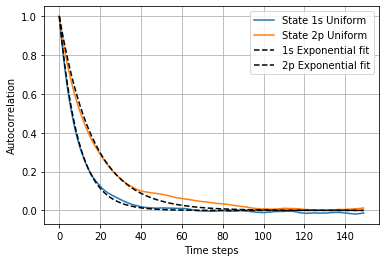

In [6]:
ac_0 = []      # Autocorrelations of state 1s
ac_1 = []      # Autocorrelations of state 2p
for time in range(150):
    ac_0.append(autocorr(test_r_0, time))
    ac_1.append(autocorr(test_r_1, time))

# Exponential fit
test_x = np.arange(150)
tau_0, err_t0 = curve_fit(exp_ac, test_x, ac_0)
tau_1, err_t1 = curve_fit(exp_ac, test_x, ac_1)
print("Exponential fit: ")
print("1s: tau = {:.4f} ± {:.4f}".format(float(tau_0), float(err_t0[0])))
print("2p: tau = {:.4f} ± {:.4f}".format(float(tau_1), float(err_t1)))

plt.plot(test_x, ac_0, label='State 1s Uniform')
plt.plot(ac_1, label='State 2p Uniform')
plt.plot(test_x, exp_ac(test_x, tau_0), linestyle='--', color='black', label='1s Exponential fit')
plt.plot(test_x, exp_ac(test_x, tau_1), linestyle='--', color='black', label='2p Exponential fit')
plt.xlabel("Time steps")
plt.ylabel("Autocorrelation")
plt.grid(True)
plt.legend()

Minimum number of steps should be chosen at least greater than 3$\cdot$tau $\rightarrow$ 50.

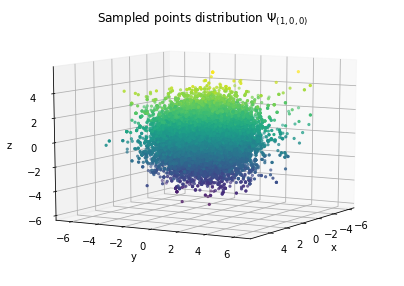

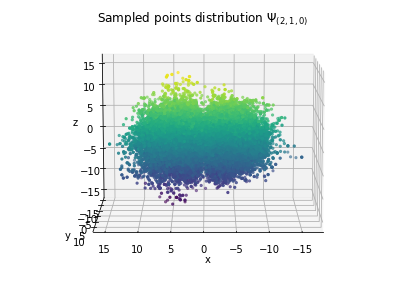

In [7]:
fig1 = plt.figure(figsize=(7,5))
ax1 = fig1.add_subplot(111, projection='3d')
ax1.scatter(test_0[:,0], test_0[:,1], test_0[:,2], c=test_0[:,2], marker='.')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')
ax1.set_title('Sampled points distribution $\Psi_{(1,0,0)}$')
ax1.view_init(10, 30)


fig2 = plt.figure(figsize=(7,5))
ax2 = fig2.add_subplot(111, projection='3d')
ax2.scatter(test_1[:,0], test_1[:,1], test_1[:,2], c=test_1[:,2], marker='.')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('z')
ax2.set_title('Sampled points distribution $\Psi_{(2,1,0)}$')
ax2.view_init(10, 90)
plt.show()

**$<r>$ for the state 1s in the hydrogen atom:**

In [8]:
M = 10**6
N = 100
step = 1.2
eq_steps = 10**4    # Equilibration steps           
mean_r_0 = np.zeros(N)
sum_r_0 = np.zeros(N)
err_r_0 = np.zeros(N)
 
rw = np.zeros((int(M/N),3))       # Array for the measure
eq_rw = np.zeros((eq_steps,3))    # Array for the equilibration period

np.random.seed(50)

lastx, eq_sum, eq_err = simulation(0, 0, 0, eq_steps, N, prob_state_0, step, 0)    # Equilibration period

final_r_0, sum_r_0, err_r_0 = simulation(lastx[0], lastx[1], lastx[2], M, N, prob_state_0, step, 1)

Block n. 0, Acceptance A = 51 %
Block n. 10, Acceptance A = 50 %
Block n. 20, Acceptance A = 51 %
Block n. 30, Acceptance A = 51 %
Block n. 40, Acceptance A = 51 %
Block n. 50, Acceptance A = 51 %
Block n. 60, Acceptance A = 51 %
Block n. 70, Acceptance A = 50 %
Block n. 80, Acceptance A = 50 %
Block n. 90, Acceptance A = 51 %


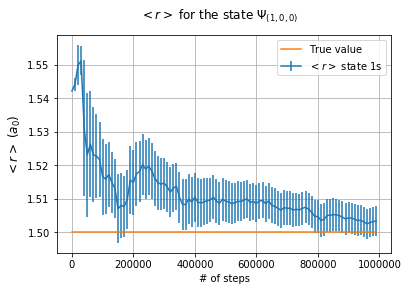

In [9]:
x = np.arange(N)
x *= int(M/N)

plt.errorbar(x, sum_r_0, yerr=err_r_0, label='$<r>$ state 1s')
plt.plot(x, np.ones(len(sum_r_0))*1.5, label='True value')
plt.xlabel('# of steps')
plt.ylabel('$<r>$ ($a_0$)', size='large')
plt.suptitle('$<r>$ for the state $\Psi_{(1,0,0)}$')
plt.grid(True)
plt.legend()

- Difference between starting point $x_0=(0,0,0)$ and $x_0=(100a_0,100a_0,100a_0)$:

In [10]:
_, far_sum_0, far_err_0 = simulation(100, 100, 100, eq_steps, N, prob_state_0, step, 0)
_, ok_sum_0, ok_err_0 = simulation(0, 0, 0, eq_steps, N, prob_state_0, step, 0)

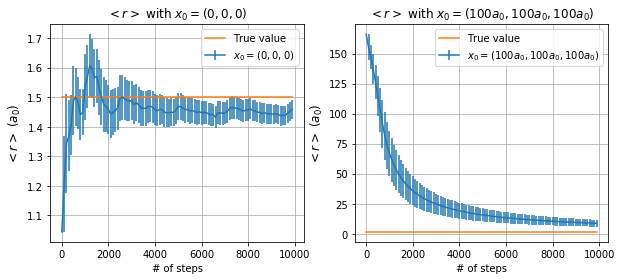

In [11]:
y = np.arange(N)
y *= int(eq_steps/N)

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))
ax1.errorbar(y, ok_sum_0, yerr=ok_err_0, label='$x_0=(0,0,0)$')
ax1.plot(y, np.ones(len(y))*1.5, label='True value')
ax1.set_xlabel('# of steps')
ax1.set_ylabel('$<r>$ ($a_0$)', size='large')
ax1.set_title('$<r>$ with $x_0 = (0,0,0)$')
ax1.grid(True)
ax1.legend()

ax2.errorbar(y, far_sum_0, yerr=far_err_0, label='$x_0=(100a_0,100a_0,100a_0)$')
ax2.plot(y, np.ones(len(y))*1.5, label='True value')
ax2.set_xlabel('# of steps')
ax2.set_ylabel('$<r>$ ($a_0$)', size='large')
ax2.set_title('$<r>$ with $x_0 = (100a_0,100a_0,100a_0)$')
ax2.grid(True)
ax2.legend()

As expected, the number of equilibration steps needed to converge is larger far from the origin

**$<r>$ for the state 2p in the hydrogen atom:**

In [12]:
M = 10**6
N = 100
step = 3.5
eq_steps = 10**4
sum_r_1 = np.zeros(N)
err_r_1 = np.zeros(N)

np.random.seed(0)

lastx, eq_sum, eq_err = simulation(3, 3, 3, eq_steps, N, prob_state_1, step, 0)    # Equilibration period

final_r_1, sum_r_1, err_r_1 = simulation(lastx[0], lastx[1], lastx[2], M, N, prob_state_1, step, 1)

Block n. 0, Acceptance A = 49 %
Block n. 10, Acceptance A = 51 %
Block n. 20, Acceptance A = 51 %
Block n. 30, Acceptance A = 49 %
Block n. 40, Acceptance A = 51 %
Block n. 50, Acceptance A = 50 %
Block n. 60, Acceptance A = 51 %
Block n. 70, Acceptance A = 50 %
Block n. 80, Acceptance A = 49 %
Block n. 90, Acceptance A = 50 %


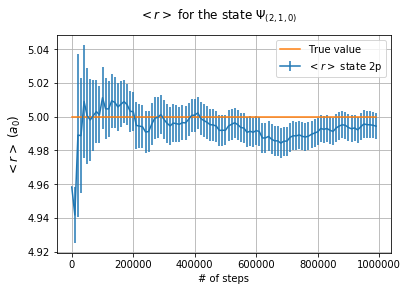

In [13]:
x = np.arange(N)
x *= int(M/N)

plt.errorbar(x, sum_r_1, yerr=err_r_1, label='$<r>$ state 2p')
plt.plot(x, np.ones(len(sum_r_1))*5, label='True value')
plt.xlabel('# of steps')
plt.ylabel('$<r>$ ($a_0$)', size='large')
plt.suptitle('$<r>$ for the state $\Psi_{(2,1,0)}$')
plt.grid(True)
plt.legend()

- Difference between starting point $x_0=(3a_0,3a_0,3a_0)$ and $x_0=(150a_0,150a_0,150a_0)$:

In [14]:
_, far_sum_1, far_err_1 = simulation(150, 150, 150, eq_steps, N, prob_state_1, step, 0)
_, ok_sum_1, ok_err_1 = simulation(3, 3, 3, eq_steps, N, prob_state_1, step, 0)

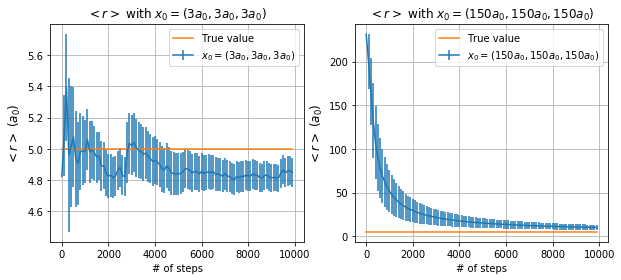

In [15]:
y = np.arange(N)
y *= int(eq_steps/N)

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))
ax1.errorbar(y, ok_sum_1, yerr=ok_err_1, label='$x_0=(3a_0,3a_0,3a_0)$')
ax1.plot(y, np.ones(len(y))*5, label='True value')
ax1.set_xlabel('# of steps')
ax1.set_ylabel('$<r>$ ($a_0$)', size='large')
ax1.set_title('$<r>$ with $x_0 = (3a_0,3a_0,3a_0)$')
ax1.grid(True)
ax1.legend()

ax2.errorbar(y, far_sum_1, yerr=far_err_1, label='$x_0=(150a_0,150a_0,150a_0)$')
ax2.plot(y, np.ones(len(y))*5, label='True value')
ax2.set_xlabel('# of steps')
ax2.set_ylabel('$<r>$ ($a_0$)', size='large')
ax2.set_title('$<r>$ with $x_0 = (150a_0,150a_0,150a_0)$')
ax2.grid(True)
ax2.legend()

As expected, the number of equilibration steps needed to converge is larger far from the origin

**Using a multivariate T(x|y) = N($x_i,\delta^2$):**

In [16]:
M = 10**6
N = 100
step = 0.75
eq_steps = 10**4    # Equilibration steps
sum_r_0g = np.zeros(N)
err_r_0g = np.zeros(N)

np.random.seed(50)

lastx, eq_sum, eq_err = simulation(0, 0, 0, eq_steps, N, prob_state_0, step, 0, p_trans='normal')    # Equilibration period

final_r_0g, sum_r_0g, err_r_0g = simulation(lastx[0], lastx[1], lastx[2], M, N, prob_state_0, step, 1, p_trans='normal')

_, far_sum_0g, far_err_0g = simulation(100, 100, 100, eq_steps, N, prob_state_0, step, 0, p_trans='normal')
_, ok_sum_0g, ok_err_0g = simulation(0, 0, 0, eq_steps, N, prob_state_0, step, 0, p_trans='normal')

Block n. 0, Acceptance A = 50 %
Block n. 10, Acceptance A = 50 %
Block n. 20, Acceptance A = 50 %
Block n. 30, Acceptance A = 51 %
Block n. 40, Acceptance A = 50 %
Block n. 50, Acceptance A = 49 %
Block n. 60, Acceptance A = 51 %
Block n. 70, Acceptance A = 50 %
Block n. 80, Acceptance A = 51 %
Block n. 90, Acceptance A = 51 %


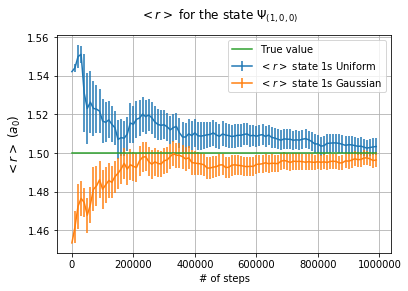

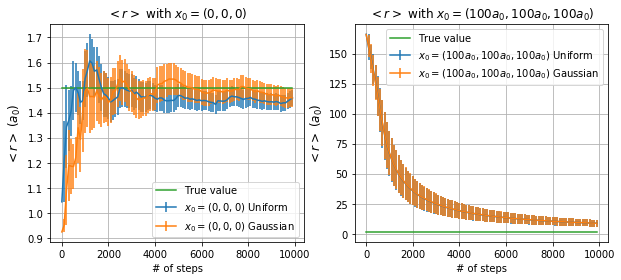

In [17]:
x = np.arange(N)
x *= int(M/N)

plt.errorbar(x, sum_r_0, yerr=err_r_0, label='$<r>$ state 1s Uniform')
plt.errorbar(x, sum_r_0g, yerr=err_r_0g, label='$<r>$ state 1s Gaussian')
plt.plot(x, np.ones(len(sum_r_0))*1.5, label='True value')
plt.xlabel('# of steps')
plt.ylabel('$<r>$ ($a_0$)', size='large')
plt.suptitle('$<r>$ for the state $\Psi_{(1,0,0)}$')
plt.grid(True)
plt.legend()

y = np.arange(N)
y *= int(eq_steps/N)

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))
ax1.errorbar(y, ok_sum_0, yerr=ok_err_0, label='$x_0=(0,0,0)$ Uniform')
ax1.errorbar(y, ok_sum_0g, yerr=ok_err_0g, label='$x_0=(0,0,0)$ Gaussian')
ax1.plot(y, np.ones(len(y))*1.5, label='True value')
ax1.set_xlabel('# of steps')
ax1.set_ylabel('$<r>$ ($a_0$)', size='large')
ax1.set_title('$<r>$ with $x_0 = (0,0,0)$')
ax1.grid(True)
ax1.legend()

ax2.errorbar(y, far_sum_0, yerr=far_err_0, label='$x_0=(100a_0,100a_0,100a_0)$ Uniform')
ax2.errorbar(y, far_sum_0g, yerr=far_err_0g, label='$x_0=(100a_0,100a_0,100a_0)$ Gaussian')
ax2.plot(y, np.ones(len(y))*1.5, label='True value')
ax2.set_xlabel('# of steps')
ax2.set_ylabel('$<r>$ ($a_0$)', size='large')
ax2.set_title('$<r>$ with $x_0 = (100a_0,100a_0,100a_0)$')
ax2.grid(True)
ax2.legend()

In [18]:
M = 10**6
N = 100
step = 2
eq_steps = 10**4    # Equilibration steps
sum_r_1g = np.zeros(N)
err_r_1g = np.zeros(N)

np.random.seed(50)

lastx, eq_sum, eq_err = simulation(3, 3, 3, eq_steps, N, prob_state_1, step, 0, p_trans='normal')    # Equilibration period

final_r_1g, sum_r_1g, err_r_1g = simulation(lastx[0], lastx[1], lastx[2], M, N, prob_state_1, step, 1, p_trans='normal')

_, far_sum_1g, far_err_1g = simulation(150, 150, 150, eq_steps, N, prob_state_1, step, 0, p_trans='normal')
_, ok_sum_1g, ok_err_1g = simulation(3, 3, 3, eq_steps, N, prob_state_1, step, 0, p_trans='normal')

Block n. 0, Acceptance A = 54 %
Block n. 10, Acceptance A = 53 %
Block n. 20, Acceptance A = 53 %
Block n. 30, Acceptance A = 54 %
Block n. 40, Acceptance A = 53 %
Block n. 50, Acceptance A = 53 %
Block n. 60, Acceptance A = 52 %
Block n. 70, Acceptance A = 53 %
Block n. 80, Acceptance A = 53 %
Block n. 90, Acceptance A = 54 %


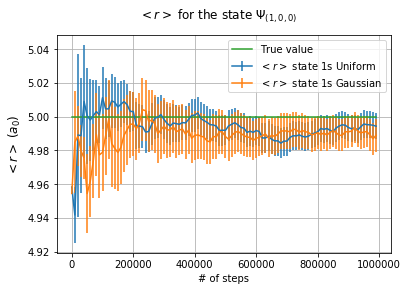

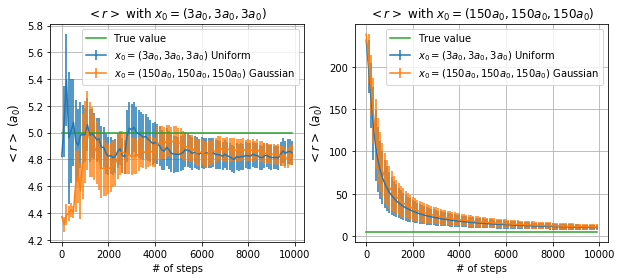

In [19]:
x = np.arange(N)
x *= int(M/N)

plt.errorbar(x, sum_r_1, yerr=err_r_1, label='$<r>$ state 1s Uniform')
plt.errorbar(x, sum_r_1g, yerr=err_r_1g, label='$<r>$ state 1s Gaussian')
plt.plot(x, np.ones(len(sum_r_1))*5., label='True value')
plt.xlabel('# of steps')
plt.ylabel('$<r>$ ($a_0$)', size='large')
plt.suptitle('$<r>$ for the state $\Psi_{(1,0,0)}$')
plt.grid(True)
plt.legend()

y = np.arange(N)
y *= int(eq_steps/N)

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))
ax1.errorbar(y, ok_sum_1, yerr=ok_err_1, label='$x_0=(3a_0,3a_0,3a_0)$ Uniform')
ax1.errorbar(y, ok_sum_1g, yerr=ok_err_1g, label='$x_0=(150a_0,150a_0,150a_0)$ Gaussian')
ax1.plot(y, np.ones(len(y))*5., label='True value')
ax1.set_xlabel('# of steps')
ax1.set_ylabel('$<r>$ ($a_0$)', size='large')
ax1.set_title('$<r>$ with $x_0 = (3a_0,3a_0,3a_0)$')
ax1.grid(True)
ax1.legend()

ax2.errorbar(y, far_sum_1, yerr=far_err_1, label='$x_0=(3a_0,3a_0,3a_0)$ Uniform')
ax2.errorbar(y, far_sum_1g, yerr=far_err_1g, label='$x_0=(150a_0,150a_0,150a_0)$ Gaussian')
ax2.plot(y, np.ones(len(y))*5., label='True value')
ax2.set_xlabel('# of steps')
ax2.set_ylabel('$<r>$ ($a_0$)', size='large')
ax2.set_title('$<r>$ with $x_0 = (150a_0,150a_0,150a_0)$')
ax2.grid(True)
ax2.legend()

I don't have found relevant differences between an Uniform and a Gaussian transition probability.